## **`Spooky authorship identification via Apache Spark`**

## **`Stage 0: Import Data`**

In [175]:
try:
    spark.stop()
except:
    pass
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from nltk.corpus import wordnet

#Create a SparkSession
spark = SparkSession.builder.getOrCreate()

#Load the data into a DataFrame
df_test = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                         ignoreTrailingWhiteSpace=True,sep=',',
                         escape='"',lineSep="\n",path='./test.csv')
df_train = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                          ignoreTrailingWhiteSpace=True,sep=',',
                          escape='"',lineSep="\n",path='./train.csv')

cleaned_df_test = df_test.fillna(0)
cleaned_df_test.show()
print(cleaned_df_test.dtypes)
print("Number of Columns:",len(cleaned_df_test.columns))
print("Number of Rows:",cleaned_df_test.count())

cleaned_df_train = df_train.fillna(0)
cleaned_df_train.show()
cleaned_df_train.groupBy('author').count().select(func.col("author").alias("Authors"),
                                                  func.col("count").alias("Book Count")).show()

print(cleaned_df_train.dtypes)
print("Number of Columns:",len(cleaned_df_train.columns))
print("Number of Rows:",cleaned_df_train.count())
print("\n")
#cleaned_df_train.select('author').select(func.distinct('author')).show()

spark.stop()

+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
|id27337|"The thick and pe...|
|id24265|That which is not...|
|id25917|I sought for repo...|
|id04951|Upon the fourth d...|
|id14549|"The tone metaphy...|
|id22505|These, the offspr...|
|id24002|What kept him fro...|
|id18982|Persuading the wi...|
|id15181|When I arose trem...|
|id21888|And by the shores...|
|id12035|Idris heard of he...|
|id17991|I say this proudl...|
|id10707|But let us glance...|
|id07101|"What a place is ...|
|id00345|At his nod I took...|
+-------+--------------------+
only showing top 20 rows

[('id', 'string'), ('text', 'string')]
Number of Columns: 2
Number of Rows: 8392
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EA

## **`Stage 1: Data Preparation`**

In [150]:
try:
    spark.stop()
except:
    pass
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.sql.functions import size, regexp_replace, when
from nltk.corpus import wordnet

spark = SparkSession.builder.getOrCreate()

df_train = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                          ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True,
                          escape='"',lineSep="\n",path='./train.csv')

cleaned_df_train = df_train.fillna(0)

"""
Edit 1: removing special characters to get rid of ',', '.', '!' and ' ?'

While it slightly improved the Naive Bayes accuracy it raised the 
logistic regression accuracy by about 6% or 7%.
"""
cleaned_df_train=cleaned_df_train.withColumn('text',regexp_replace('text',"[^0-9a-zA-Z_\-]+",' '))

cleaned_df_train.show()

tokenizer = Tokenizer(inputCol="text",outputCol="tokens")

token_df_train = tokenizer.transform(cleaned_df_train)
token_df_train.drop('id').drop('text').show(n=5,truncate=100)
#df_train = token_df_train.select('tokens',size('tokens').alias('tokens_length'))
#df_train.show()

stopwords_remover = StopWordsRemover(inputCol="tokens",outputCol="filtered_tokens")
token_df_train = stopwords_remover.transform(token_df_train)
#token_df_train.show()

df_train = token_df_train.select('id','tokens',
                                 'filtered_tokens',
                                 size('tokens').alias('tokens_length'))
df_train = df_train.select('id','tokens','filtered_tokens',
                           'tokens_length',
                           size('filtered_tokens').alias('filtered_tokens_length'))
df_train.show()


+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process howe...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
|id22965|A youth passed in...|   MWS|
|id09674|The astronomer pe...|   EAP|
|id13515|The surcingle hun...|   EAP|
|id19322|I knew that you c...|   EAP|
|id00912|I confess that ne...|   MWS|
|id16737|He shall find tha...|   MWS|
|id16607|Here we barricade...|   EAP|
|id19764|Herbert West need...|   HPL|
|id18886|The farm like gro...|   HPL|
|id17189|But a glance will...|   EAP|
|id12799|He had escaped me...|   MWS|
|id08441|To these speeches...|   EAP|
|id13117|Her native sprigh...|   MWS|
|id14862|I even went so fa...|   EAP|
|id20836|His facial aspect...|   HPL|
+-------+--------------------+------+
only showing top 20 rows

+------+------------------------------------------------------

## **`Stage 2: Feature Extraction`**

In [151]:
vectorizer = CountVectorizer(inputCol="filtered_tokens",outputCol="vectorized_tokens")
model = vectorizer.fit(token_df_train)
vector_df_train = model.transform(token_df_train)
#vector_df_train.show()

idf = IDF(inputCol="vectorized_tokens",outputCol="tfidf")
model = idf.fit(vector_df_train)
idf_df_train = model.transform(vector_df_train)
#idf_df_train.show()

normalizer = Normalizer(inputCol="tfidf",outputCol="normalized_features")

norm_df_train = normalizer.transform(idf_df_train)
#norm_df_train.drop('tokens').show()

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, normalizer])
processed_data = pipeline.fit(cleaned_df_train).transform(cleaned_df_train)

pr_df = processed_data.drop('tokens').drop('vectorized_tokens').drop('text')

pr_df.show()

+-------+------+--------------------+--------------------+--------------------+
|     id|author|     filtered_tokens|               tfidf| normalized_features|
+-------+------+--------------------+--------------------+--------------------+
|id26305|   EAP|[process, however...|(24948,[8,19,42,5...|(24948,[8,19,42,5...|
|id17569|   HPL|[never, occurred,...|(24948,[8,14,305,...|(24948,[8,14,305,...|
|id11008|   EAP|[left, hand, gold...|(24948,[52,76,106...|(24948,[52,76,106...|
|id27763|   MWS|[lovely, spring, ...|(24948,[44,53,111...|(24948,[44,53,111...|
|id12958|   HPL|[finding, nothing...|(24948,[7,71,161,...|(24948,[7,71,161,...|
|id22965|   MWS|[youth, passed, s...|(24948,[14,44,47,...|(24948,[14,44,47,...|
|id09674|   EAP|[astronomer, perh...|(24948,[72,116,13...|(24948,[72,116,13...|
|id13515|   EAP|[surcingle, hung,...|(24948,[113,606,9...|(24948,[113,606,9...|
|id19322|   EAP|[knew, say, stere...|(24948,[5,20,22,2...|(24948,[5,20,22,2...|
|id00912|   MWS|[confess, neither...|(24

## **`Stage 3: Machine Learning`**

In [155]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import StringIndexer, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

pr_reduced_df = pr_df.drop('filtered_tokens').drop('id').drop('tfidf')

string_indexer = StringIndexer(inputCol='author', outputCol='author_ind')
str_ind = string_indexer.fit(pr_reduced_df)
df_rd_st = str_ind.transform(pr_reduced_df).drop('author')
df_rd_st.show()

pd_rnd_split = df_rd_st.randomSplit([0.8, 0.2], seed=42)

train = pd_rnd_split[0]
test = pd_rnd_split[1]#.drop('author')

lr = LogisticRegression(featuresCol='normalized_features',labelCol='author_ind')

from pyspark.ml.tuning import ParamGridBuilder
"""
Edit 2: Changed the parameter grid values that I originally got by
simply testing different values.
"""
param_grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0.01, 0.1, 1.0]).\
    addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).\
    build()

lr_eval = MulticlassClassificationEvaluator(labelCol='author_ind')
lr_cv = CrossValidator(estimator=lr,estimatorParamMaps=param_grid,evaluator=lr_eval,
                       numFolds=5)
"""
Edit 3: Realized I sent in the wrong PDF with wrong training Dataframe
used df_rd_st instead of train
"""
lr_cv_model = lr_cv.fit(train)

lr_cv_pred = lr_cv_model.transform(test)
lr_cv_pred.show()

"""
 I realized that by comparing the author count with prediction count I could get 
 a very simple and clear picture of accuracy.
"""
lr_cv_pred.groupBy('prediction').count().select(func.col("prediction").alias("predictions"),
                                                func.col("count").alias("Prediction count")).show()
lr_cv_pred.groupBy('author_ind').count().select(func.col("author_ind").alias("authors"),
                                                func.col("count").alias("Author count")).show()



+--------------------+----------+
| normalized_features|author_ind|
+--------------------+----------+
|(24948,[8,19,42,5...|       0.0|
|(24948,[8,14,305,...|       2.0|
|(24948,[52,76,106...|       0.0|
|(24948,[44,53,111...|       1.0|
|(24948,[7,71,161,...|       2.0|
|(24948,[14,44,47,...|       1.0|
|(24948,[72,116,13...|       0.0|
|(24948,[113,606,9...|       0.0|
|(24948,[5,20,22,2...|       0.0|
|(24948,[347,425,4...|       1.0|
|(24948,[46,119,12...|       1.0|
|(24948,[175,1486,...|       0.0|
|(24948,[15,138,22...|       2.0|
|(24948,[11,70,108...|       2.0|
|(24948,[145,816,1...|       0.0|
|(24948,[13,26,108...|       1.0|
|(24948,[22,36,64,...|       0.0|
|(24948,[29,44,59,...|       1.0|
|(24948,[0,4,7,20,...|       0.0|
|(24948,[20,29,62,...|       2.0|
+--------------------+----------+
only showing top 20 rows

+--------------------+----------+--------------------+--------------------+----------+
| normalized_features|author_ind|       rawPrediction|         probabil

In [156]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='normalized_features',labelCol='author_ind')
nb_eval = MulticlassClassificationEvaluator()

param_grid = ParamGridBuilder().\
    addGrid(nb.smoothing, [0, 1, 2, 4]).\
    build()

nb_eval = MulticlassClassificationEvaluator(labelCol='author_ind')
nb_cv = CrossValidator(estimator=nb,estimatorParamMaps=param_grid,evaluator=nb_eval, numFolds=5)
nb_cv_model = nb_cv.fit(train)

nb_cv_pred = nb_cv_model.transform(test)

nb_cv_pred.show()

nb_cv_pred.groupBy('prediction').count().select(func.col("prediction").alias("predictions"),
                                                func.col("count").alias("Prediction count")).show()
nb_cv_pred.groupBy('author_ind').count().select(func.col("author_ind").alias("authors"),
                                                func.col("count").alias("Author count")).show()


+--------------------+----------+--------------------+--------------------+----------+
| normalized_features|author_ind|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|   (24948,[0],[1.0])|       2.0|[-7.4500989770581...|[0.46718006951215...|       0.0|
|(24948,[0,1,2,34,...|       0.0|[-46.911100345003...|[0.83059008153819...|       0.0|
|(24948,[0,1,2,40,...|       0.0|[-49.175119883615...|[0.94980585991011...|       0.0|
|(24948,[0,1,3,16,...|       2.0|[-34.553602389388...|[0.19806387009846...|       2.0|
|(24948,[0,1,5,33,...|       0.0|[-43.428561487643...|[0.57911314822965...|       0.0|
|(24948,[0,1,7,21,...|       1.0|[-31.480310657839...|[0.16299824137403...|       1.0|
|(24948,[0,1,8,19,...|       0.0|[-62.402742568789...|[0.86937752858316...|       0.0|
|(24948,[0,1,10,11...|       0.0|[-66.175124040330...|[0.91386402523290...|       0.0|
|(24948,[0,1,12,18...|       1.0|[-35.31222

## **`Stage 4: Evaluation and Visualization`**

In [157]:

lr_acc=lr_eval.setMetricName('accuracy').evaluate(lr_cv_pred)
print("Accuracy score of Logistic reg:",lr_acc)

lr_pre=lr_eval.setMetricName('weightedPrecision').evaluate(lr_cv_pred)
print("Percision of Logistic reg:",lr_pre)

lr_f1=lr_eval.setMetricName('f1').evaluate(lr_cv_pred)
print("F1 score of Logistic reg:",lr_f1)
print("\n")

"""
This is what my values should have been

Accuracy score of Logistic reg: 0.7501943508681005
Percision of Logistic reg: 0.7658532663090063
F1 score of Logistic reg: 0.7491559572892939


Accuracy score of Naive Bayes: 0.8020212490282457
Percision of Naive Bayes: 0.8186626082451129
F1 score of Naive Bayes: 0.8013610671182676

"""

nb_acc=nb_eval.setMetricName('accuracy').evaluate(nb_cv_pred)
print("Accuracy score of Naive Bayes:",nb_acc)

nb_pre=nb_eval.setMetricName('weightedPrecision').evaluate(nb_cv_pred)
print("Percision of Naive Bayes:",nb_pre)

nb_f1=nb_eval.setMetricName('f1').evaluate(nb_cv_pred)
print("F1 score of Naive Bayes:",nb_f1)



Accuracy score of Logistic reg: 0.8191241254210936
Percision of Logistic reg: 0.8298305669986193
F1 score of Logistic reg: 0.8192778993275995


Accuracy score of Naive Bayes: 0.8121274941694739
Percision of Naive Bayes: 0.8224383793337156
F1 score of Naive Bayes: 0.8117319711446049


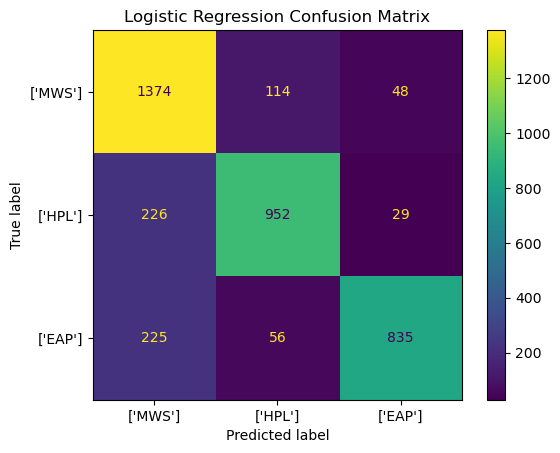

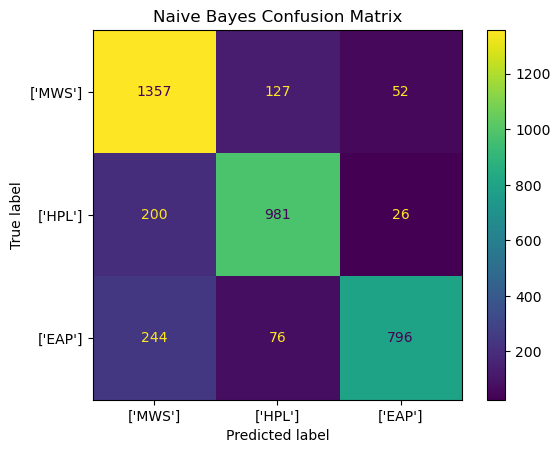

In [158]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#lr_tp=lr_eval.setMetricName('weightedTruePositiveRate').evaluate(lr_cv_pred)
#print(lr_tp)
#lr_fp=lr_eval.setMetricName('weightedFalsePositiveRate').evaluate(lr_cv_pred)
#print(lr_fp)

"""
Originally, I wanted to use an rdd for this but it was giving too much trouble
and wouldn't store values properly.
"""

pred_label_lr = lr_cv_pred.select('author_ind','prediction').toPandas()
pred_label_nb = nb_cv_pred.select('author_ind','prediction').toPandas()

confusion_lr = confusion_matrix(pred_label_lr['author_ind'], pred_label_lr['prediction'])

df_author =cleaned_df_train.select('author')
author = np.array(df_author.dropDuplicates(['author']).collect())

display = ConfusionMatrixDisplay(confusion_matrix=confusion_lr,display_labels=author)
display.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

confusion_nb = confusion_matrix(pred_label_nb['author_ind'], pred_label_nb['prediction'])

df_author =cleaned_df_train.select('author')
author = np.array(df_author.dropDuplicates(['author']).collect())


display = ConfusionMatrixDisplay(confusion_matrix=confusion_nb,display_labels=author)
display.plot()
plt.title("Naive Bayes Confusion Matrix")
plt.show()

## **`Reflection`**

In [ ]:
"""
 The logistic regression is more reliable in this case than Naive Bayes, but I 
think is more because I haven't adjusted the parameters quite right. I say
this because I tried to make k-means cluster scatter plot to see how distinct
the data would actual be. However, I was clearly doing something wrong because
one have 2, the second would have one, and the last would have 15 thousand and
change.

What I would do next is possibly trying to lemmatize the words to increase the
reliability of both models. Another problem I notice rather late is that some
of my tokens seem to have a ',' attached to them. I wasn't able to remove it but
I think I was just trying too hard to use pyspark libaries to solve it rather
something like replace().
"""

## **`Changelog`**

In [ ]:
"""
Edit 1: removing special characters to get rid of ',', '.', '!' and ' ?'

While it slightly improved the Naive Bayes accuracy it raised the 
logistic regression accuracy by about 6% or 7%.

Edit 2: Changed the parameter grid values that I originally got by
simply testing different values.

Edit 3: Realized I sent in the wrong PDF with wrong training Dataframe
used df_rd_st instead of train
"""


## **`M6 More Spooky authorship identification via Apache Spark`**

## **`Task 1: Spark SQL Mechanics`**

In [159]:
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, when, col, udf
import pyspark.sql.functions as func

import findspark
findspark.init()
spark = SparkSession.builder.getOrCreate()

df_train = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                          ignoreTrailingWhiteSpace=True,sep=',',
                          escape='"',lineSep="\n",path='./train.csv')

df_train = df_train.fillna(0)

df_train.createOrReplaceTempView("spooky_sentences")

result_df = spark.sql("""
    SELECT text AS sentence,
        size(split(text, ' ')) as word_count
    FROM spooky_sentences
    ORDER BY word_count DESC
""")
result_df.show(10)
result_df.show(5, truncate=False)


+--------------------+----------+
|            sentence|word_count|
+--------------------+----------+
|Diotima approache...|       861|
|Oh no I will beco...|       594|
|They are gone for...|       445|
|To chambers of pa...|       377|
|As for those who ...|       335|
|Burning with the ...|       267|
|I have much to sa...|       256|
|I invited him to ...|       191|
|Oh God help me Le...|       190|
|It was in Rome th...|       186|
+--------------------+----------+
only showing top 10 rows

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [160]:

temp = df_train
temp.createOrReplaceTempView("test")

spark.sql("""
    SELECT author, SUM(size(split(text, ' '))) AS total_words
    FROM test
    GROUP BY author
""").show()

df_full_name = temp.withColumn('author', 
                          when(col('author')=="MWS","Mary Shelley")
                         .when(col('author')=="HPL","H.P. Lovecraft")
                          .when(col('author')=="EAP","Edgar Allan Poe"))
#df_full_name.show()

df_full_name.createOrReplaceTempView("grp_order_By")

df_full_TW = spark.sql("""
    SELECT author, SUM(size(split(text, ' '))) AS total_words
    FROM grp_order_By
    GROUP BY author
""")
df_full_TW.show()

+------+-----------+
|author|total_words|
+------+-----------+
|   MWS|     165710|
|   HPL|     156651|
|   EAP|     200995|
+------+-----------+

+---------------+-----------+
|         author|total_words|
+---------------+-----------+
| H.P. Lovecraft|     156651|
|Edgar Allan Poe|     200995|
|   Mary Shelley|     165710|
+---------------+-----------+



## **`Task 2: Data Loading and Query Types`**

In [161]:
df_full_name.createOrReplaceTempView("spooky_sentences")

result_df = spark.sql("""
    SELECT id, author, text AS sentence,
        size(split(text, ' ')) as word_count
    FROM spooky_sentences
    ORDER BY word_count DESC
""")
result_df.show(10)

def wordy(word_count):
    if word_count > 30:
        author_category = 'wordy'
    elif word_count <= 7:
        author_category = 'pity'
    else:
        author_category = 'not wordy'
    return author_category

wordy_udf = udf(wordy)

author_category = wordy_udf(result_df.word_count)

result_df = result_df.withColumn('author_category', wordy_udf('word_count'))
result_df.show()

result_df.groupBy('author_category').count().select(func.col("author_category").alias("author_categorys"),
                                                func.col("count").alias("ac count")).show()


+-------+---------------+--------------------+----------+
|     id|         author|            sentence|word_count|
+-------+---------------+--------------------+----------+
|id27184|   Mary Shelley|Diotima approache...|       861|
|id17485|   Mary Shelley|Oh no I will beco...|       594|
|id13677|   Mary Shelley|They are gone for...|       445|
|id20439|   Mary Shelley|To chambers of pa...|       377|
|id20549|   Mary Shelley|As for those who ...|       335|
|id12818|Edgar Allan Poe|Burning with the ...|       267|
|id20687|Edgar Allan Poe|I have much to sa...|       256|
|id03319|   Mary Shelley|I invited him to ...|       191|
|id02143|   Mary Shelley|Oh God help me Le...|       190|
|id05745|   Mary Shelley|It was in Rome th...|       186|
+-------+---------------+--------------------+----------+
only showing top 10 rows

+-------+---------------+--------------------+----------+---------------+
|     id|         author|            sentence|word_count|author_category|
+-------+-----

## **`Task 3: Advanced SQL Functions and Expressions`**

In [164]:
result_df.createOrReplaceTempView("concat_lower_sentences")
#result_df.show()      

# This is to combine all sentences into one

MS=result_df.rdd.map(lambda x: x.sentence.lower() 
                     if x.author == 'Mary Shelley' else "").collect()
MS= ''.join(MS)

EAP=result_df.rdd.map(lambda x: x.sentence.lower() 
                      if x.author == 'Edgar Allan Poe' else "").collect()
EAP= ''.join(EAP)
HPL=result_df.rdd.map(lambda x: x.sentence.lower() 
                      if x.author == 'H.P. Lovecraft' else "").collect()
HPL= ''.join(HPL)

df = spark.createDataFrame([('Mary Shelley',MS),('Edgar Allan Poe',EAP),
                            ('H.P. Lovecraft',HPL)],['author','concatenated_text'])
df.show(truncate=100)




+---------------+----------------------------------------------------------------------------------------------------+
|         author|                                                                                   concatenated_text|
+---------------+----------------------------------------------------------------------------------------------------+
|   Mary Shelley|diotima approached the fountain seated herself on a mossy mound near it and her disciples placed ...|
|Edgar Allan Poe|burning with the chivalry of this determination, the great touch and go, in the next 'tea pot,' c...|
| H.P. Lovecraft|a weak, filtered glow from the rain harassed street lamps outside, and a feeble phosphorescence f...|
+---------------+----------------------------------------------------------------------------------------------------+



## **`Task 4: Views and Temporary Tables`**

In [42]:
result_df.createOrReplaceTempView("random_sentences")

df_fliter = spark.sql("""
    SELECT author, sentence, word_count 
    FROM random_sentences WHERE word_count > 30
""")

df_fliter = spark.sql("""
    SELECT author, sentence, word_count 
    FROM random_sentences 
    WHERE word_count > 30
    ORDER BY author
""")
df = spark.createDataFrame(df_fliter.rdd.takeSample(False,num=3))
df.drop('word_count').show(truncate=100)

+---------------+----------------------------------------------------------------------------------------------------+
|         author|                                                                                            sentence|
+---------------+----------------------------------------------------------------------------------------------------+
| H.P. Lovecraft|His own face was in shadow, and he wore a wide brimmed hat which somehow blended perfectly with t...|
|   Mary Shelley|When it seemed destined that all were to die, we were reckless of the how and when now that the v...|
|Edgar Allan Poe|I now began to feel my way in the science, and soon came to understand that, provided a man had a...|
+---------------+----------------------------------------------------------------------------------------------------+



## **`Task 5: Error Handling and Debugging`**

In [44]:
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, when, col, udf, sum
import pyspark.sql.functions as func

import findspark
findspark.init()
spark = SparkSession.builder.getOrCreate()

#test Exception
try:
    df_train = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                          ignoreTrailingWhiteSpace=True,sep=',',
                          escape='"',lineSep="\n",path='./not_There.csv')
    
except Exception as e:
    print("Error reading the file: File not found.")

Error reading the file: File not found.


## **`Task 6: Spark SQL for Machine Learning`**

In [79]:
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, when, col, udf
import pyspark.sql.functions as func

import findspark
findspark.init()
spark = SparkSession.builder.getOrCreate()


df_train = spark.read.csv(header=True,inferSchema=True,multiLine=True,
                          ignoreTrailingWhiteSpace=True,sep=',',
                          escape='"',lineSep="\n",path='./train.csv')
    
df_train.createOrReplaceTempView("data_view")
cleaned_data = spark.sql("SELECT * FROM data_view WHERE text IS NOT NULL")

df_full_name = cleaned_data.withColumn('author', 
                          when(col('author')=="MWS","Mary Shelley")
                         .when(col('author')=="HPL","H.P. Lovecraft")
                          .when(col('author')=="EAP","Edgar Allan Poe"))

df_full_name.createOrReplaceTempView("spooky_sentences")

result_df = spark.sql("""
    SELECT author, COUNT(DISTINCT word) / CAST(SUM(size(split(text, ' '))) AS FLOAT) AS lexical_density
    FROM (
        SELECT author, text, explode(split(lower(text), ' ')) AS word
        FROM spooky_sentences
    ) subquery
    GROUP BY author
""")
result_df.show()

+---------------+--------------------+
|         author|     lexical_density|
+---------------+--------------------+
| H.P. Lovecraft| 0.00391539133379026|
|Edgar Allan Poe|0.003231444268655...|
|   Mary Shelley|0.002501946629938...|
+---------------+--------------------+

